# 📌 Insurance Premium Prediction CLEAN_PIPELINE

**Author** : Thierry CAROLE <br>
**Date** : 22/04/2025

# 🧾Goals

The objectives of this challenge is to predict insurance premiums based on various factors.

https://www.kaggle.com/competitions/regression-with-an-insurance-dataset-bt-2-ds/overview

# Load libraries

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
import math
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor,Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_log_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# 📁 Loading data

In [2]:
# Determining training data path
data_path = "../data/raw_data/train.csv"

# Check if the file exists
if os.path.exists(data_path):
    data = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [3]:
# Make a copy of the data
data_copy = data.copy()

In [4]:
# Overview of the first lines
data.head(2)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0


In [5]:
# Remove empty space within column names
for col in data.columns:
    data.rename(columns = {col : col.replace(' ','_')},inplace=True)

In [6]:
# Let's delete the "id" column
data.drop(columns=['id'], inplace=True)

# 🔎 Data Mining (EDA)

**Objective**: To understand trends, distributions, missing values, etc.

## Info

In [7]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual_Income         1155051 non-null  float64
 3   Marital_Status        1181471 non-null  object 
 4   Number_of_Dependents  1090328 non-null  float64
 5   Education_Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health_Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy_Type           1200000 non-null  object 
 10  Previous_Claims       835971 non-null   float64
 11  Vehicle_Age           1199994 non-null  float64
 12  Credit_Score          1062118 non-null  float64
 13  Insurance_Duration    1199999 non-null  float64
 14  Policy_Start_Date     1200000 non-

## To date

In [8]:
# Convert "Policy_Start_Date" into DateTime
# data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'])
# data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'], format='%Y-%m-%d')
data['Policy_Start_Date'] = pd.to_datetime(data['Policy_Start_Date'])

In [9]:
data['Policy_Start_Date_year'] = data['Policy_Start_Date'].dt.year
data['Policy_Start_Date_month'] = data['Policy_Start_Date'].dt.month
data['Policy_Start_Date_day'] = data['Policy_Start_Date'].dt.day

In [10]:
data.drop(columns='Policy_Start_Date', inplace=True)

## Statistics

In [11]:
# Descriptive statistics
data.describe();

## Histograms

In [12]:
def plot_histplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.histplot(data=num_df,kde=True, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [13]:
# # Display hist plots for numerical features.
# plot_histplot_sns(data)

## Count plots

In [14]:
def plot_countplot_sns(df):
        """
    Plots Seaborn countplots of categorical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of categorical columns
    """
        #Only select categorical features         
        cat_df = df.select_dtypes(exclude='number')

        vars = cat_df.columns
        n = len(cat_df.columns)
        cols = 3
        rows = math.ceil(n / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        axes = axes.flatten()

        for i, var in enumerate(vars):
            sns.countplot(data=cat_df, x=var, ax=axes[i])
            axes[i].set_title(var)

        # Delete unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

In [15]:
# # Display hist plots for numerical features.
# plot_countplot_sns(data)

## Check duplicates

In [16]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        df (Dataframe) without duplicated rows
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    print(f"Number of duplicated rows : {df.duplicated().sum()}")

    if df.duplicated().sum()>0:
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print("Duplicated rows have been removed")
        return df_no_duplicates
    else:
        return "No duplicated rows found !"    

In [17]:
# Check of duplicated values within dataset
check_duplicates(data)

Number of rows : 1200000
Number of duplicated rows : 0


'No duplicated rows found !'

## Correlation

### Correlation between numerical features

In [18]:
def create_correlation_heatmap(df): 
    """
    Plots correlation heatmap of numerical features.
    Args:
        df (DataFrame): Raw data
    Returns:
        Plot of correlation heatmap.
    """
    num_df = df.select_dtypes(include='number')
    correlation_matrix = num_df.corr()
    column_names = correlation_matrix.columns
    sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr"); 

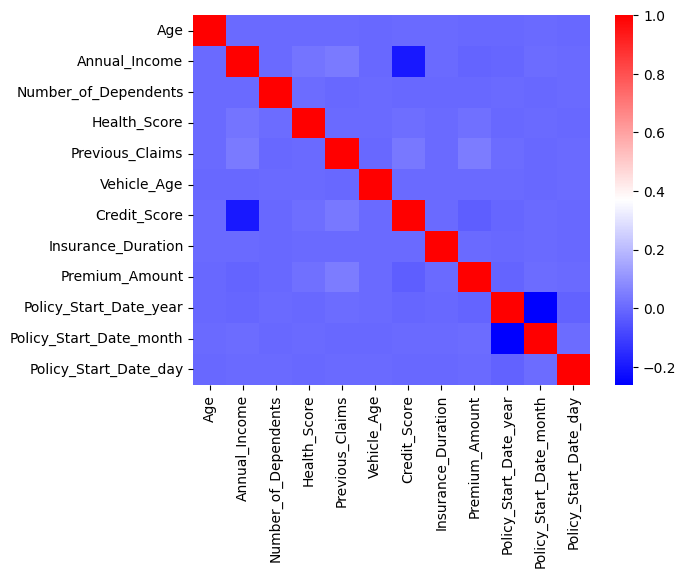

In [19]:
# Heatmap of pairwise correlations
create_correlation_heatmap(data)

### Correlation matrix

In [20]:
def create_pair_correlation_df(df):
        """
    Creates a dataframe listing pair correlations and absolute correlations
    Args:
        df (DataFrame): Raw data
    Returns:
        New df with pair correlations
    """
        num_df = df.select_dtypes(include='number')
    
        #Create a dataframe listing pair correlations and absolute correlations
        correlation_matrix = num_df.corr()

        # Converting the correlation matrix into a DataFrame
        corr_df = correlation_matrix.stack().reset_index()

        # Renaming the columns
        corr_df.columns = ['feature_1','feature_2', 'correlation']

        # Remove "self correlations"
        no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
        corr_df = corr_df[no_self_correlation]

        corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

        corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
        return corr_df

In [21]:
# Dataframe listing pair correlations and absolute correlations
corr_df = create_pair_correlation_df(data)
display(corr_df)

,feature_1,feature_2,correlation,absolute_correlation
129,Policy_Start_Date_month,Policy_Start_Date_year,-0.261312,0.261312
118,Policy_Start_Date_year,Policy_Start_Date_month,-0.261312,0.261312
73,Credit_Score,Annual_Income,-0.201423,0.201423
18,Annual_Income,Credit_Score,-0.201423,0.201423
56,Previous_Claims,Premium_Amount,0.046874,0.046874
...,...,...,...,...
7,Age,Insurance_Duration,-0.000064,0.000064
92,Insurance_Duration,Premium_Amount,-0.000028,0.000028
103,Premium_Amount,Insurance_Duration,-0.000028,0.000028
1,Age,Annual_Income,-0.000009,0.000009


In [22]:
def create_target_feature_corr(df, target_name):
    """
    Creates a dataframe listing correlations between target feature and the other features
    Args:
        - df (DataFrame): Raw data
        - target name : string
    Returns:
        New df with correlations between target and the other features
    """
    corr_df = create_pair_correlation_df(df)
    corr_target_feat_df = corr_df[corr_df["feature_1"] == target_name].head(40)
    return corr_target_feat_df

In [23]:
#Create a dataframe listing correlations between a feature and the target and absolute correlations
target_name = 'Premium_Amount'
corr_target_feat_df = create_target_feature_corr(data, target_name)
display(corr_target_feat_df)

,feature_1,feature_2,correlation,absolute_correlation
100,Premium_Amount,Previous_Claims,0.046874,0.046874
102,Premium_Amount,Credit_Score,-0.026014,0.026014
99,Premium_Amount,Health_Score,0.014704,0.014704
97,Premium_Amount,Annual_Income,-0.012390,0.012390
105,Premium_Amount,Policy_Start_Date_year,-0.011084,0.011084
106,Premium_Amount,Policy_Start_Date_month,0.006702,0.006702
96,Premium_Amount,Age,-0.002430,0.002430
98,Premium_Amount,Number_of_Dependents,-0.000976,0.000976
101,Premium_Amount,Vehicle_Age,0.000391,0.000391
107,Premium_Amount,Policy_Start_Date_day,0.000291,0.000291


## Check Missing data

In [24]:
# Function 
def show_missing_data(data):
    
        """
    Creates a dataframe listing the features and associated percentage of missing values.
    Args:
        - df (DataFrame): Raw data
    Returns:
        - New dataframe listing the features and associated percentage of missing values.
        - List of column names of features which have missing values
    """       
        
        # Counting the percentage of NaN for each column
        missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

        # missing_data
        missing_data = missing_data[missing_data > 0]

        #Missing data column names
        missing_cols = missing_data.index.values.tolist()

        #Show missing data in percent
        return missing_data, missing_cols

In [25]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Previous_Claims         30.335750
Occupation              29.839583
Credit_Score            11.490167
Number_of_Dependents     9.139333
Customer_Feedback        6.485333
Health_Score             6.173000
Annual_Income            3.745750
Age                      1.558750
Marital_Status           1.544083
Vehicle_Age              0.000500
Insurance_Duration       0.000083
dtype: float64

**Let's delete the rows with the least missing values of the numerical features that have the least correlation with the target.**

In [26]:
# Delete the missing rows of the numerical features that have the least correlation with the target.
subset_cols = ['Insurance_Duration','Vehicle_Age','Number_of_Dependents','Age']
data.dropna(axis=0, subset=subset_cols, inplace=True)

**Impute median values of numerical features the most correlated to target**

In [27]:
# Impute median value on remaining important numerical features correlated to target
for col in missing_cols:
    if col in data.select_dtypes(include='number').columns and col not in subset_cols:      
        # Add missing indicator
        data[f"{col}_missing"] = data[col].isna().astype(int)
        
        # Impute missing values (mean/median or custom)
        imputer = SimpleImputer(strategy='median')
        data[col] = imputer.fit_transform(data[[col]])

**Check missing values**

In [28]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Occupation           29.853041
Customer_Feedback     6.440163
Marital_Status        1.526425
dtype: float64

**Impute most frequent values of categorical features the most correlated to target**

In [29]:
# Impute most frequent values of categorical features the most correlated to target
for col in missing_cols:
    if col in data.select_dtypes(exclude='number').columns:      
        # Add missing indicator
        data[f"{col}_missing"] = data[col].isna().astype(int)
        
        # Impute most used value
        data[col] = data[col].fillna(data[col].mode()[0])

In [30]:
# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
missing_perc_df

Series([], dtype: float64)

In [31]:
missing_cols

[]

# Check correlation again

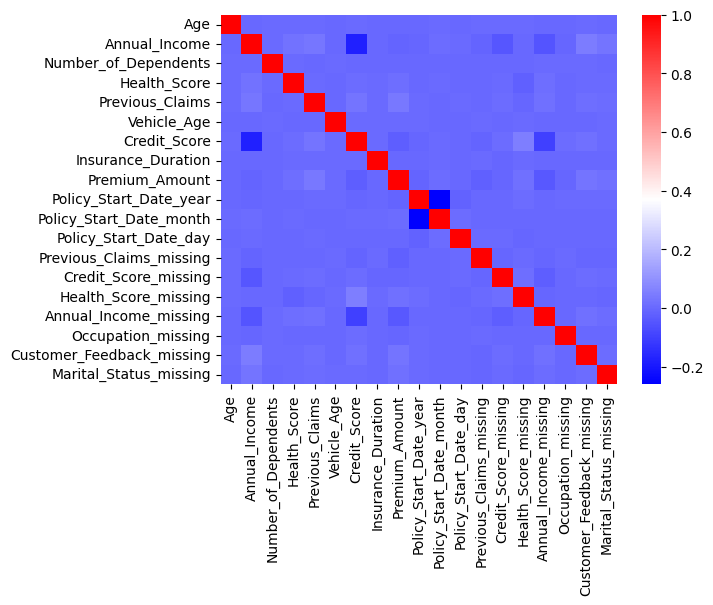

In [32]:
# Heatmap of pairwise correlations
create_correlation_heatmap(data)

In [33]:
#Create a dataframe listing correlations between a feature and the target and absolute correlations
target_name = 'Premium_Amount'
corr_target_feat_df = create_target_feature_corr(data, target_name)
display(corr_target_feat_df)

,feature_1,feature_2,correlation,absolute_correlation
167,Premium_Amount,Annual_Income_missing,-0.040235,0.040235
156,Premium_Amount,Previous_Claims,0.039751,0.039751
169,Premium_Amount,Customer_Feedback_missing,0.026251,0.026251
158,Premium_Amount,Credit_Score,-0.025007,0.025007
164,Premium_Amount,Previous_Claims_missing,-0.019327,0.019327
170,Premium_Amount,Marital_Status_missing,0.017385,0.017385
166,Premium_Amount,Health_Score_missing,0.016337,0.016337
155,Premium_Amount,Health_Score,0.013737,0.013737
161,Premium_Amount,Policy_Start_Date_year,-0.011457,0.011457
153,Premium_Amount,Annual_Income,-0.010288,0.010288


## Check outliers

### Visual check for outliers

In [34]:
def plot_boxplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.boxplot(data=num_df, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [35]:
# # Display box plots for numerical features.
# plot_boxplot_sns(data)

In [36]:
data.select_dtypes(include='number').columns

Index(['Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
       'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
       'Premium_Amount', 'Policy_Start_Date_year', 'Policy_Start_Date_month',
       'Policy_Start_Date_day', 'Previous_Claims_missing',
       'Credit_Score_missing', 'Health_Score_missing', 'Annual_Income_missing',
       'Occupation_missing', 'Customer_Feedback_missing',
       'Marital_Status_missing'],
      dtype='object')

### Numerical check for outliers

In [37]:
def extract_cols_outliers(df):
        """
    Extract the columns with outliers.
    Args:
        df (DataFrame): Raw data
    Returns:
        - a list of numerical columns with outliers
        - a list of nnumerical columns without outliers
    """
        # Identify the columns with outliers
        numerical_columns_w_outliers = []
        numerical_columns_no_outliers = []
        
        num_df = df.select_dtypes(include='number')
        numerical_columns = num_df.columns
        
        for col in numerical_columns: 
            # Calculate IQR
            iqr_value = iqr(df[col],nan_policy='omit')
        
            #Calculate 1st quartile
            q1 = np.percentile(df[col],25)
        
            #Calculate 3rd quartile
            q3 = np.percentile(df[col],75)
        
            #Calculate lower limit below which data point is considered an outlier
            outlier_lim_low = q1 - 1.5 * iqr_value
        
            #Calculate higher limit above which data point is considered an outlier
            outlier_lim_high = q3 + 1.5 * iqr_value
            
            #Calculate number of 'low' outliers
            outlier_condition_low = df[col] < outlier_lim_low
            number_outliers_low = len(df[outlier_condition_low][col])
            
            #Calculate number of 'high' outliers
            outlier_condition_high = df[col] > outlier_lim_high
            number_outliers_high = len(df[outlier_condition_high][col])
            
            #Calculate total number of outliers
            number_outliers_total = number_outliers_low + number_outliers_high
            
            #If any outliers in column, column is added to a list of columns with outliers
            if number_outliers_total > 0:
                numerical_columns_w_outliers.append(col)
            elif number_outliers_total == 0:
                numerical_columns_no_outliers.append(col)

        return numerical_columns_w_outliers, numerical_columns_no_outliers

In [38]:
numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(data)

In [39]:
numerical_columns_w_outliers

['Annual_Income',
 'Previous_Claims',
 'Premium_Amount',
 'Credit_Score_missing',
 'Health_Score_missing',
 'Annual_Income_missing',
 'Customer_Feedback_missing',
 'Marital_Status_missing']

In [40]:
numerical_columns_no_outliers

['Age',
 'Number_of_Dependents',
 'Health_Score',
 'Vehicle_Age',
 'Credit_Score',
 'Insurance_Duration',
 'Policy_Start_Date_year',
 'Policy_Start_Date_month',
 'Policy_Start_Date_day',
 'Previous_Claims_missing',
 'Occupation_missing']

# ⚙️ Data preprocessing

## Scaling

### Columns with outliers

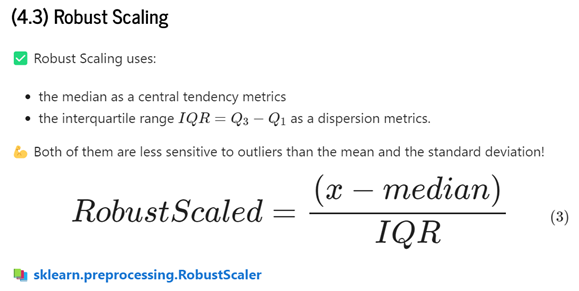

In [41]:
numerical_columns_w_outliers.remove("Premium_Amount")

In [42]:
# Describe columns with outliers
data[numerical_columns_w_outliers].describe()

,Annual_Income,Previous_Claims,Credit_Score_missing,Health_Score_missing,Annual_Income_missing,Customer_Feedback_missing,Marital_Status_missing
count,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06
mean,3.233349e+04,1.000744e+00,1.149598e-01,6.223832e-02,3.752057e-02,6.440163e-02,1.526425e-02
std,3.155171e+04,8.185940e-01,3.189735e-01,2.415880e-01,1.900337e-01,2.454671e-01,1.226020e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.603000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.389100e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.391600e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.499970e+05,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [43]:
#Instanciate, fit, transform with robust scaler
rb_scaler = RobustScaler()
data[numerical_columns_w_outliers] = rb_scaler.fit_transform(data[numerical_columns_w_outliers])

In [44]:
# Describe columns with outliers after robust scaling
data[numerical_columns_w_outliers].describe()

,Annual_Income,Previous_Claims,Credit_Score_missing,Health_Score_missing,Annual_Income_missing,Customer_Feedback_missing,Marital_Status_missing
count,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06
mean,2.390759e-01,7.443928e-04,1.149598e-01,6.223832e-02,3.752057e-02,6.440163e-02,1.526425e-02
std,8.934871e-01,8.185940e-01,3.189735e-01,2.415880e-01,1.900337e-01,2.454671e-01,1.226020e-01
min,-6.765214e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-4.329284e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.670716e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.571093e+00,8.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Columns WITHOUT outliers

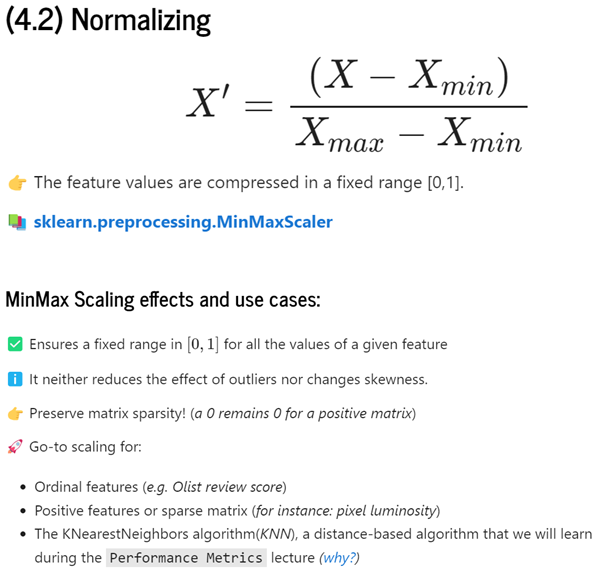


In [45]:
# Describe columns with NO outliers
data[numerical_columns_no_outliers].describe()

,Age,Number_of_Dependents,Health_Score,Vehicle_Age,Credit_Score,Insurance_Duration,Policy_Start_Date_year,Policy_Start_Date_month,Policy_Start_Date_day,Previous_Claims_missing,Occupation_missing
count,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06
mean,4.114751e+01,2.010283e+00,2.554703e+01,9.566675e+00,5.936836e+02,5.018778e+00,2.021622e+03,6.491063e+00,1.570732e+01,3.040002e-01,2.985304e-01
std,1.354130e+01,1.417288e+00,1.181001e+01,5.776461e+00,1.409527e+02,2.594558e+00,1.475418e+00,3.433919e+00,8.810157e+00,4.599829e-01,4.576136e-01
min,1.800000e+01,0.000000e+00,2.012237e+00,0.000000e+00,3.000000e+02,1.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+01,1.000000e+00,1.656737e+01,5.000000e+00,4.840000e+02,3.000000e+00,2.020000e+03,4.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00
50%,4.100000e+01,2.000000e+00,2.458300e+01,1.000000e+01,5.960000e+02,5.000000e+00,2.022000e+03,6.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00
75%,5.300000e+01,3.000000e+00,3.375111e+01,1.500000e+01,7.060000e+02,7.000000e+00,2.023000e+03,9.000000e+00,2.300000e+01,1.000000e+00,1.000000e+00
max,6.400000e+01,4.000000e+00,5.897591e+01,1.900000e+01,8.490000e+02,9.000000e+00,2.024000e+03,1.200000e+01,3.100000e+01,1.000000e+00,1.000000e+00


In [46]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
data[numerical_columns_no_outliers] = minmax_scaler.fit_transform(data[numerical_columns_no_outliers])

In [47]:
# Describe columns with NO outliers after minmax scaling
data[numerical_columns_no_outliers].describe()

,Age,Number_of_Dependents,Health_Score,Vehicle_Age,Credit_Score,Insurance_Duration,Policy_Start_Date_year,Policy_Start_Date_month,Policy_Start_Date_day,Previous_Claims_missing,Occupation_missing
count,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06,1.073358e+06
mean,5.032067e-01,5.025707e-01,4.131543e-01,5.035092e-01,5.349428e-01,5.023472e-01,5.244567e-01,4.991875e-01,4.902441e-01,3.040002e-01,2.985304e-01
std,2.943760e-01,3.543220e-01,2.073254e-01,3.040243e-01,2.567445e-01,3.243197e-01,2.950837e-01,3.121745e-01,2.936719e-01,4.599829e-01,4.576136e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.608696e-01,2.500000e-01,2.555160e-01,2.631579e-01,3.351548e-01,2.500000e-01,2.000000e-01,2.727273e-01,2.333333e-01,0.000000e+00,0.000000e+00
50%,5.000000e-01,5.000000e-01,3.962308e-01,5.263158e-01,5.391621e-01,5.000000e-01,6.000000e-01,4.545455e-01,5.000000e-01,0.000000e+00,0.000000e+00
75%,7.608696e-01,7.500000e-01,5.571775e-01,7.894737e-01,7.395264e-01,7.500000e-01,8.000000e-01,7.272727e-01,7.333333e-01,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Encoding

In [48]:
# Extract categorical columns from original dataset
categorical_columns = data.select_dtypes(include = 'object').columns
categorical_columns

Index(['Gender', 'Marital_Status', 'Education_Level', 'Occupation', 'Location',
       'Policy_Type', 'Customer_Feedback', 'Smoking_Status',
       'Exercise_Frequency', 'Property_Type'],
      dtype='object')

### One hot encoder

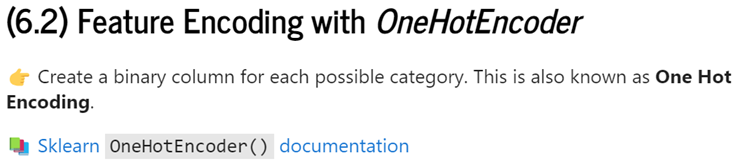

In [49]:
# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['Gender', 'Marital_Status', 'Occupation','Location','Smoking_Status','Exercise_Frequency','Property_Type']

In [50]:
# Instantiate, fit
ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
ohe_encoder.fit(data[categorical_columns_ohe])

#Transform 
data[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(data[categorical_columns_ohe]);
print(data.shape)

#Drop initial features
data.drop(columns=categorical_columns_ohe, inplace=True)
print(data.shape)

(1073358, 47)
(1073358, 40)


### Ordinal encoder

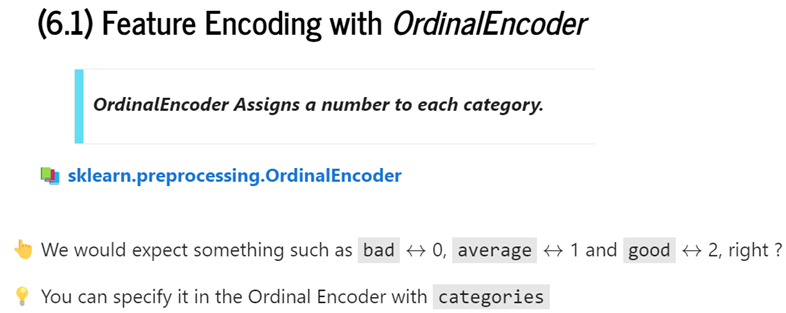

In [51]:
# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']

In [52]:
# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

Policy_Type_cat=['Basic','Comprehensive','Premium']
Education_Level_cat=['High School', "Bachelor's","Master's",'PhD' ]
Customer_Feedback_cat=['Poor','Average','Good']

ordered_categories = [Policy_Type_cat, Education_Level_cat,Customer_Feedback_cat]

In [53]:
# Instantiate, fit using ordinal encoding
ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
ordinal_encoder.fit(data[categorical_columns_ordinal]);

#Transform
data[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(data[categorical_columns_ordinal])

print(data.shape)

(1073358, 40)


## PREPROCESS

In [54]:
# Function to remove empty spaces in column names
def remove_empty_spaces_in_cols(df):
        """
    Removes empty spaces in column names
    Args:
        df (DataFrame): Raw data
    Returns:
        df (Dataframe) without empty spaces into column names
    """
        for col in df.columns:
            df.rename(columns = {col : col.replace(' ','_')},inplace=True)
        return df

In [55]:
def extract_year_month_day(df, column):
        """
        Removes empty spaces in column names
        Args:
            - df (DataFrame): Raw data
            - column (str) : column to convert to date time
        Returns:
            - df (Dataframe) with 3 additional columns from 'column' : year, month and day
            - column has been dropped
        """

        df[column] = pd.to_datetime(df[column])
        df[f"{column}_year"] = df[column].dt.year
        df[f"{column}_month"] = df[column].dt.month
        df[f"{column}_day"] = df[column].dt.day
        df.drop(columns=column, inplace=True)
        return df

In [56]:
# Delete the missing rows of the numerical features that have the least correlation with the target.
def drop_na_least_corr_cols(df, subset_list):
            """
        Delete the missing rows of the numerical features that have the least correlation with the target.
        Args:
            - df (DataFrame): Raw data
            - subset_list (list) : list of columns with the least correlation to target
        Returns:
            - df (Dataframe) after dropping missing rows of the least correlated cols to target
        """
            df.dropna(axis=0, subset=subset_list, inplace=True)

In [57]:
# # Retrieve original data
# original_data = data_copy

# # remove empty spaces in column names
# original_data = remove_empty_spaces_in_cols(original_data)

# # Convert to datetime AND Extract year, month, day
# original_data = extract_year_month_day(original_data, 'Policy_Start_Date')

# # Check of duplicated values within dataset
# check_duplicates(original_data)

# # Show Missing values in percentage
# missing_perc_df, missing_cols = show_missing_data(original_data)

# # Delete the missing rows of the numerical features that have the least correlation with the target.
# subset_cols = ['Insurance_Duration','Vehicle_Age','Number_of_Dependents','Age']
# drop_na_least_corr_cols(original_data, subset_cols)

# # Show Missing values in percentage
# missing_perc_df, missing_cols = show_missing_data(original_data)

# # Impute median value on remaining important numerical features correlated to target
# for col in missing_cols:
#     if col in original_data.select_dtypes(include='number').columns and col not in subset_cols:   
#         # Add missing indicator
#         original_data[f"{col}_missing"] = original_data[col].isna().astype(int)
        
#         # Impute missing values (mean/median or custom)
#         imputer = SimpleImputer(strategy='median')
#         original_data[col] = imputer.fit_transform(original_data[[col]])

# # Impute most frequent values of categorical features the most correlated to target
# for col in missing_cols:
#     if col in original_data.select_dtypes(exclude='number').columns:   
#         # Add missing indicator
#         original_data[f"{col}_missing"] = original_data[col].isna().astype(int)
        
#         # Impute most used value
#         original_data[col] = original_data[col].fillna(original_data[col].mode()[0])

# # Extract columns with outliers and columns without outliers
# numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(original_data)

# # Scaling
# numerical_columns_w_outliers.remove("Premium_Amount")

# #Instanciate, fit, transform with robust scaler
# rb_scaler = RobustScaler()
# original_data[numerical_columns_w_outliers] = rb_scaler.fit_transform(original_data[numerical_columns_w_outliers])

# #Instanciate, fit, transform with minmax scaler
# minmax_scaler = MinMaxScaler()
# original_data[numerical_columns_no_outliers] = minmax_scaler.fit_transform(original_data[numerical_columns_no_outliers])

# # Categorical columns to be encoded with OneHotEncoder
# categorical_columns_ohe = ['Gender', 'Marital_Status', 'Occupation','Location','Smoking_Status','Exercise_Frequency','Property_Type']

# # Instantiate, fit
# ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
# ohe_encoder.fit(original_data[categorical_columns_ohe])

# #Transform 
# original_data[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(original_data[categorical_columns_ohe]);
# print(original_data.shape)

# #Drop initial features
# original_data.drop(columns=categorical_columns_ohe, inplace=True)
# print(original_data.shape)

# # Categorical columns to be encoded with OrdinalEncoder
# categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']

# # Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# # (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

# Policy_Type_cat=['Basic','Comprehensive','Premium']
# Education_Level_cat=['High School', "Bachelor's","Master's",'PhD' ]
# Customer_Feedback_cat=['Poor','Average','Good']

# ordered_categories = [Policy_Type_cat, Education_Level_cat,Customer_Feedback_cat]

# # Instantiate, fit using ordinal encoding
# ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
# ordinal_encoder.fit(original_data[categorical_columns_ordinal]);

# #Transform
# original_data[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(original_data[categorical_columns_ordinal])

# print(original_data.shape)





# display(f"Shape of data is : {original_data.shape}")

# # display(original_data)
# # display(original_data.columns)

In [58]:
def preprocess_data(df):

    # Let's delete the "id" column
    df.drop(columns=['id'], inplace=True)
    
    # remove empty spaces in column names
    df = remove_empty_spaces_in_cols(df)
    
    # Convert to datetime AND Extract year, month, day
    df = extract_year_month_day(df, 'Policy_Start_Date')
    
    # Check of duplicated values within dataset
    check_duplicates(df)
    
    # Show Missing values in percentage
    missing_perc_df, missing_cols = show_missing_data(df)
    
    # Delete the missing rows of the numerical features that have the least correlation with the target.
    subset_cols = ['Insurance_Duration','Vehicle_Age','Number_of_Dependents','Age']
    drop_na_least_corr_cols(df, subset_cols)
    
    # Show Missing values in percentage
    missing_perc_df, missing_cols = show_missing_data(df)
    
    # Impute median value on remaining important numerical features correlated to target
    for col in missing_cols:
        if col in df.select_dtypes(include='number').columns and col not in subset_cols:   
            # Add missing indicator
            df[f"{col}_missing"] = df[col].isna().astype(int)
            
            # Impute missing values (mean/median or custom)
            imputer = SimpleImputer(strategy='median')
            df[col] = imputer.fit_transform(df[[col]])
    
    # Impute most frequent values of categorical features the most correlated to target
    for col in missing_cols:
        if col in df.select_dtypes(exclude='number').columns:   
            # Add missing indicator
            df[f"{col}_missing"] = df[col].isna().astype(int)
            
            # Impute most used value
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Extract columns with outliers and columns without outliers
    numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(df)
    
    # Scaling
    numerical_columns_w_outliers.remove("Premium_Amount")
    
    #Instanciate, fit, transform with robust scaler
    rb_scaler = RobustScaler()
    df[numerical_columns_w_outliers] = rb_scaler.fit_transform(df[numerical_columns_w_outliers])
    
    #Instanciate, fit, transform with minmax scaler
    minmax_scaler = MinMaxScaler()
    df[numerical_columns_no_outliers] = minmax_scaler.fit_transform(df[numerical_columns_no_outliers])
    
    # Categorical columns to be encoded with OneHotEncoder
    categorical_columns_ohe = ['Gender', 'Marital_Status', 'Occupation','Location','Smoking_Status','Exercise_Frequency','Property_Type']
    
    # Instantiate, fit
    ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
    ohe_encoder.fit(df[categorical_columns_ohe])
    
    #Transform 
    df[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(df[categorical_columns_ohe]);
    
    #Drop initial features
    df.drop(columns=categorical_columns_ohe, inplace=True)
    
    # Categorical columns to be encoded with OrdinalEncoder
    categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']
    
    # Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
    # (KEEP THE ORDER of XXX_cat AND in the subsequent lists)
    
    Policy_Type_cat=['Basic','Comprehensive','Premium']
    Education_Level_cat=['High School', "Bachelor's","Master's",'PhD' ]
    Customer_Feedback_cat=['Poor','Average','Good']
    
    ordered_categories = [Policy_Type_cat, Education_Level_cat,Customer_Feedback_cat]
    
    # Instantiate, fit using ordinal encoding
    ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
    ordinal_encoder.fit(df[categorical_columns_ordinal]);
    
    #Transform
    df[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(df[categorical_columns_ordinal])
    return df

In [59]:
def preprocess_test_data(df):

    # Let's delete the "id" column
    df.drop(columns=['id'], inplace=True)
    
    # remove empty spaces in column names
    df = remove_empty_spaces_in_cols(df)
    
    # Convert to datetime AND Extract year, month, day
    df = extract_year_month_day(df, 'Policy_Start_Date')
    
    # Check of duplicated values within dataset
    check_duplicates(df)
    
    # Show Missing values in percentage
    missing_perc_df, missing_cols = show_missing_data(df)
    
    # Delete the missing rows of the numerical features that have the least correlation with the target.
    subset_cols = ['Insurance_Duration','Vehicle_Age','Number_of_Dependents','Age']
    drop_na_least_corr_cols(df, subset_cols)
    
    # Show Missing values in percentage
    missing_perc_df, missing_cols = show_missing_data(df)
    
    # Impute median value on remaining important numerical features correlated to target
    for col in missing_cols:
        if col in df.select_dtypes(include='number').columns and col not in subset_cols:   
            # Add missing indicator
            df[f"{col}_missing"] = df[col].isna().astype(int)
            
            # Impute missing values (mean/median or custom)
            imputer = SimpleImputer(strategy='median')
            df[col] = imputer.fit_transform(df[[col]])
    
    # Impute most frequent values of categorical features the most correlated to target
    for col in missing_cols:
        if col in df.select_dtypes(exclude='number').columns:   
            # Add missing indicator
            df[f"{col}_missing"] = df[col].isna().astype(int)
            
            # Impute most used value
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Extract columns with outliers and columns without outliers
    numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(df)
    
    # # Scaling
    # numerical_columns_w_outliers.remove("Premium_Amount")
    
    #Instanciate, fit, transform with robust scaler
    rb_scaler = RobustScaler()
    df[numerical_columns_w_outliers] = rb_scaler.fit_transform(df[numerical_columns_w_outliers])
    
    #Instanciate, fit, transform with minmax scaler
    minmax_scaler = MinMaxScaler()
    df[numerical_columns_no_outliers] = minmax_scaler.fit_transform(df[numerical_columns_no_outliers])
    
    # Categorical columns to be encoded with OneHotEncoder
    categorical_columns_ohe = ['Gender', 'Marital_Status', 'Occupation','Location','Smoking_Status','Exercise_Frequency','Property_Type']
    
    # Instantiate, fit
    ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
    ohe_encoder.fit(df[categorical_columns_ohe])
    
    #Transform 
    df[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(df[categorical_columns_ohe]);
    
    #Drop initial features
    df.drop(columns=categorical_columns_ohe, inplace=True)
    
    # Categorical columns to be encoded with OrdinalEncoder
    categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']
    
    # Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
    # (KEEP THE ORDER of XXX_cat AND in the subsequent lists)
    
    Policy_Type_cat=['Basic','Comprehensive','Premium']
    Education_Level_cat=['High School', "Bachelor's","Master's",'PhD' ]
    Customer_Feedback_cat=['Poor','Average','Good']
    
    ordered_categories = [Policy_Type_cat, Education_Level_cat,Customer_Feedback_cat]
    
    # Instantiate, fit using ordinal encoding
    ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
    ordinal_encoder.fit(df[categorical_columns_ordinal]);
    
    #Transform
    df[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(df[categorical_columns_ordinal])
    return df

In [60]:
# Retrieve original data
original_data = data_copy
display(original_data.head())
original_data_preproc = preprocess_data(original_data)
display(original_data_preproc.head())

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


Number of rows : 1200000
Number of duplicated rows : 0


,Age,Annual_Income,Number_of_Dependents,Education_Level,Health_Score,Policy_Type,Previous_Claims,Vehicle_Age,Credit_Score,Insurance_Duration,Customer_Feedback,Premium_Amount,Policy_Start_Date_year,Policy_Start_Date_month,Policy_Start_Date_day,Previous_Claims_missing,Credit_Score_missing,Health_Score_missing,Annual_Income_missing,Occupation_missing,Customer_Feedback_missing,Marital_Status_missing,Gender_Male,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Smoking_Status_Yes,Exercise_Frequency_Daily,Exercise_Frequency_Monthly,Exercise_Frequency_Rarely,Exercise_Frequency_Weekly,Property_Type_Apartment,Property_Type_Condo,Property_Type_House
0,0.021739,-0.391980,0.25,1.0,0.361397,2.0,1.0,0.894737,0.131148,0.500,0.0,2869.0,0.8,1.000000,0.733333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.456522,0.220514,0.75,2.0,0.238002,1.0,0.0,0.631579,0.717668,0.125,1.0,1483.0,0.8,0.454545,0.366667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.108696,0.048452,0.75,0.0,0.792879,2.0,0.0,0.736842,0.539162,0.250,2.0,567.0,0.8,0.727273,0.966667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.065217,3.340526,0.50,1.0,0.156695,0.0,0.0,0.000000,0.122040,0.000,0.0,765.0,1.0,0.454545,0.366667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.065217,0.446295,0.25,1.0,0.322378,2.0,-1.0,0.421053,0.542805,0.375,0.0,2022.0,0.4,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# 🧠 Modeling / Machine Learning

In [61]:
# Define X and y
target_name = 'Premium_Amount'
X = original_data_preproc.drop(columns= target_name)
y = original_data_preproc[target_name]

In [62]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (751350, 39)
Shape of X_test : (322008, 39)
Shape of y_train : (751350,)
Shape of y_test : (322008,)


In [63]:
def root_mean_squared_log_error(y_test, y_pred):
        """
    Calcuates the root mean squared logarithmic error between real target values and predicted target values
    Args:
        - y_test: real target values
        - y_pred: predicted target values
    Returns:
        Root mean squared logarithmic error
    """
        return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Wrapper to use in cros_val_score function (I want the root mean squared log error to be as small as possible)
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [64]:
# %%time

# # Selection of models to try out (BE CAREFUL : 1h46min to cross validate !!!)
# # linear_models = [LinearRegression(), 
# #                  Ridge(random_state=42),
# #                  Lasso(random_state=42),
# #                  RandomForestRegressor(random_state=42),
# #                  GradientBoostingRegressor(random_state=42),
# #                  SGDRegressor(random_state=42), 
# #                  XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42),
# #                  LGBMRegressor(random_state=42),
# #                  ElasticNet(random_state=42)]

# linear_models = [LinearRegression(), LGBMRegressor(random_state=42)]

# rmsle_scores = {}

# # Train and evaluate the models
# for model in linear_models:
#     rmsle = -cross_val_score(model, X_train, y_train, cv=5, scoring= rmsle_scorer).mean()
#     rmsle_scores[str(model)[:str(model).find('(')]] = rmsle
#     print(f"{model} is finished!")

# # Formatting the results into a dataframe
# rmsle_scores_df = pd.DataFrame(rmsle_scores, index=[0])
# rmsle_scores_df = rmsle_scores_df.T\
#                                 .reset_index()\
#                                 .rename(columns={0:'Mean_score', 'index' : 'Model'})\
#                                 .sort_values('Mean_score', ascending=True)
# display(rmsle_scores_df)

# print("*****************************")
# print(f"The best model from cross validation (in regard to scoring method) seems to be : {rmsle_scores_df.Model.head(1).values[0]}")
# print("*****************************")

In [65]:
# Fit model
model = LGBMRegressor()
fitted_model = model.fit(X_train, y_train)

# Predictions
y_pred = fitted_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 751350, number of used features: 39
[LightGBM] [Info] Start training from score 1100.636976


In [66]:
root_mean_squared_log_error(y_test, y_pred)

np.float64(1.130293028867905)

# 📊 Results analysis / visualization

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 1073358, number of used features: 39
[LightGBM] [Info] Start training from score 1100.167558


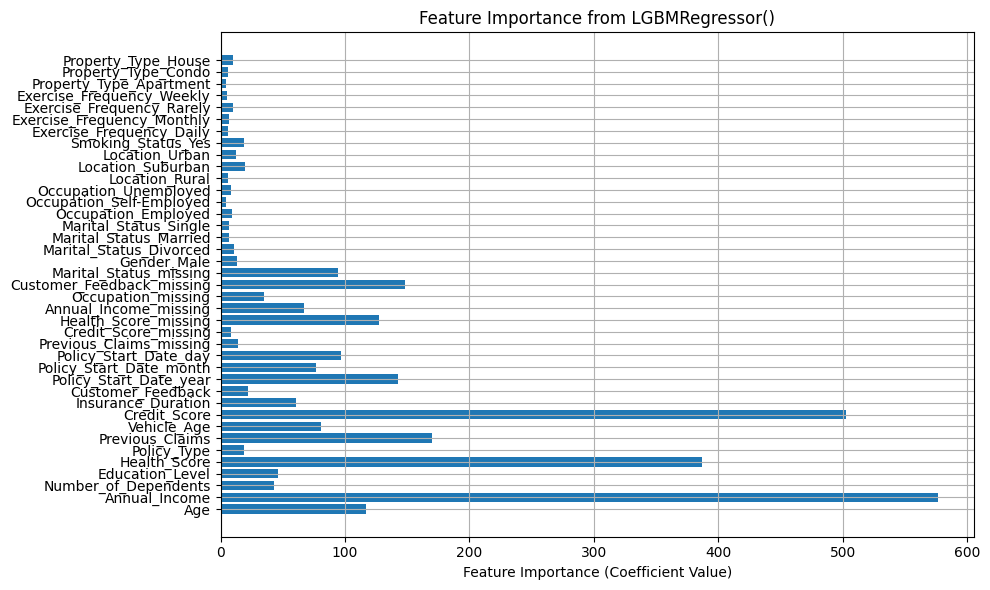

In [67]:
# Train
model = LGBMRegressor()
model.fit(X, y)

# Get feature importance (the model's coefficients)
# Plot
plt.figure(figsize=(10,6))
plt.barh(X.columns.tolist(), model.feature_importances_)
plt.xlabel('Feature Importance (Coefficient Value)')
plt.title(f'Feature Importance from {model}')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧪Conclusion and recommendations

## Fitting model on entire test data

In [68]:
# Let's fit the model on the whole data
model = LGBMRegressor()
fitted_model = model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 1073358, number of used features: 39
[LightGBM] [Info] Start training from score 1100.167558


## Prepare test data

In [69]:
# Determining test data path
data_path = "../data/raw_data/test.csv"

# Check if the file exists
if os.path.exists(data_path):
    test_data = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [70]:
# Overview of the first lines
display(test_data.shape)
test_data.head(2)

(800000, 20)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment


In [71]:
# Determining test data path
data_path = "../data/raw_data/sample_submission.csv"

# Check if the file exists
if os.path.exists(data_path):
    sample_submission = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [72]:
# Overview of the first lines
sample_submission.head(2)

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545


## Prediction of test data

In [73]:
# Preprocess test data
display(test_data.head())
test_data_preproc = preprocess_test_data(test_data)
display(test_data_preproc.head())

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


Number of rows : 800000
Number of duplicated rows : 0


,Age,Annual_Income,Number_of_Dependents,Education_Level,Health_Score,Policy_Type,Previous_Claims,Vehicle_Age,Credit_Score,Insurance_Duration,Customer_Feedback,Policy_Start_Date_year,Policy_Start_Date_month,Policy_Start_Date_day,Previous_Claims_missing,Credit_Score_missing,Health_Score_missing,Annual_Income_missing,Occupation_missing,Customer_Feedback_missing,Marital_Status_missing,Gender_Male,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Smoking_Status_Yes,Exercise_Frequency_Daily,Exercise_Frequency_Monthly,Exercise_Frequency_Rarely,Exercise_Frequency_Weekly,Property_Type_Apartment,Property_Type_Condo,Property_Type_House
0,0.217391,-0.614245,1.00,1.0,0.107003,0.0,0.0,1.000000,0.539162,0.000,0.0,0.8,0.454545,0.100000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.282609,2.897214,0.50,2.0,0.208879,2.0,0.0,0.736842,0.131148,0.875,2.0,1.0,0.272727,0.700000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.630435,-0.194701,0.00,3.0,0.404201,1.0,0.0,0.842105,0.945355,1.000,1.0,0.8,0.272727,0.133333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.217391,0.183689,0.75,3.0,0.062116,1.0,0.0,0.157895,0.856102,0.500,0.0,0.8,0.818182,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.130435,-0.371493,0.50,0.0,0.181517,2.0,0.0,0.736842,0.828780,0.750,1.0,0.4,0.909091,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [74]:
# Predictions
y_pred = fitted_model.predict(test_data_preproc)

In [75]:
y_pred

array([1270.76467316, 1113.6882047 , 1078.99787796, ..., 1120.02630802,
       1115.00077541, 1049.55506483], shape=(715507,))

In [76]:
y_pred_df = pd.DataFrame(y_pred, columns=['Premium Amount'])
# y_pred_df['id'] = 
y_pred_df.shape

(715507, 1)

# 📦 Appendices / references